<a href="https://colab.research.google.com/github/ddverse-bot/BrainMRIclassensemble/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debangidey","key":"d2cbfff678814ea49dc2b461ec082801"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.62GB/s]


In [ ]:
import os


print("Content directory files:", os.listdir("/content"))

DATA_DIR = "/content"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")

print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

Content directory files: ['.config', 'Training', 'kaggle.json', 'Testing', 'sample_data']
Training classes: ['glioma', 'notumor', 'meningioma', 'pituitary']
Testing classes: ['glioma', 'notumor', 'meningioma', 'pituitary']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
from collections import Counter


train_counts = Counter(train_gen.classes)
test_counts = Counter(val_gen.classes)


print("Train:", train_counts)
print("Test :", test_counts)

Train: Counter({np.int32(2): 1276, np.int32(3): 1166, np.int32(1): 1072, np.int32(0): 1057})
Test : Counter({np.int32(2): 319, np.int32(3): 291, np.int32(1): 267, np.int32(0): 264})


In [ ]:
!pip install timm scikit-learn --quiet

In [ ]:
import torch, timm, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [ ]:
DATA_DIR = "/content"

train_ds = datasets.ImageFolder(f"{DATA_DIR}/Training", transform=train_tfms)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/Testing", transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(train_ds.classes)
print(train_ds.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
def get_model(name):
    model = timm.create_model(name, pretrained=True)
    model.reset_classifier(num_classes)
    return model.to(device)

In [ ]:
models = {
    "ResNet50": get_model("resnet50"),
    "DenseNet121": get_model("densenet121"),
    "ConvNeXt-Tiny": get_model("convnext_tiny")
}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
def train(model, loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for x, y in tqdm(loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f}")

In [ ]:
for name, model in models.items():
    print(f"\nTraining {name}")
    train(model, train_loader, epochs=5)


Training ResNet50


100%|██████████| 179/179 [00:58<00:00,  3.08it/s]


Epoch 1/5 | Loss: 0.8754


100%|██████████| 179/179 [00:58<00:00,  3.06it/s]


Epoch 2/5 | Loss: 0.2393


100%|██████████| 179/179 [00:58<00:00,  3.06it/s]


Epoch 3/5 | Loss: 0.1286


100%|██████████| 179/179 [00:59<00:00,  3.02it/s]


Epoch 4/5 | Loss: 0.0740


100%|██████████| 179/179 [00:58<00:00,  3.06it/s]


Epoch 5/5 | Loss: 0.0500

Training DenseNet121


100%|██████████| 179/179 [01:03<00:00,  2.82it/s]


Epoch 1/5 | Loss: 0.3594


100%|██████████| 179/179 [00:59<00:00,  3.00it/s]


Epoch 2/5 | Loss: 0.0894


100%|██████████| 179/179 [00:58<00:00,  3.07it/s]


Epoch 3/5 | Loss: 0.0435


100%|██████████| 179/179 [00:58<00:00,  3.07it/s]


Epoch 4/5 | Loss: 0.0292


100%|██████████| 179/179 [00:58<00:00,  3.06it/s]


Epoch 5/5 | Loss: 0.0261

Training ConvNeXt-Tiny


100%|██████████| 179/179 [01:39<00:00,  1.81it/s]


Epoch 1/5 | Loss: 0.3277


100%|██████████| 179/179 [01:32<00:00,  1.93it/s]


Epoch 2/5 | Loss: 0.0811


100%|██████████| 179/179 [01:32<00:00,  1.93it/s]


Epoch 3/5 | Loss: 0.0516


100%|██████████| 179/179 [01:32<00:00,  1.94it/s]


Epoch 4/5 | Loss: 0.0360


100%|██████████| 179/179 [01:32<00:00,  1.94it/s]

Epoch 5/5 | Loss: 0.0211


In [ ]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            preds = model(x).argmax(1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1

In [ ]:
results = {}
for name, model in models.items():
    acc, f1 = evaluate(model, test_loader)
    results[name] = (acc, f1)
    print(f"{name} → Accuracy: {acc:.4f}, Macro-F1: {f1:.4f}")

ResNet50 → Accuracy: 0.9832, Macro-F1: 0.9822
DenseNet121 → Accuracy: 0.9939, Macro-F1: 0.9934
ConvNeXt-Tiny → Accuracy: 0.9550, Macro-F1: 0.9555


In [ ]:
def ensemble(models, loader):
    y_true, y_pred = [], []

    for x, y in loader:
        x = x.to(device)
        probs = []

        for model in models.values():
            model.eval()
            with torch.no_grad():
                probs.append(torch.softmax(model(x), dim=1))

        mean_prob = torch.mean(torch.stack(probs), dim=0)
        preds = mean_prob.argmax(1).cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(preds)

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1

In [ ]:
ens_acc, ens_f1 = ensemble(models, test_loader)
print(f"\nENSEMBLE → Accuracy: {ens_acc:.4f}, Macro-F1: {ens_f1:.4f}")


ENSEMBLE → Accuracy: 0.9954, Macro-F1: 0.9953


In [ ]:
weights = torch.tensor([0.2, 0.5, 0.3], device=device)  # ResNet, DenseNet, ConvNeXt

def weighted_ensemble(models, loader, weights):
    y_true, y_pred = [], []

    for x, y in loader:
        x = x.to(device)
        probs = []

        for model in models.values():
            model.eval()
            with torch.no_grad():
                probs.append(torch.softmax(model(x), dim=1))

        probs = torch.stack(probs)  # [3, B, C]
        weighted_prob = (weights[:, None, None] * probs).sum(dim=0)

        preds = weighted_prob.argmax(1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1

In [ ]:
ens_acc, ens_f1 = weighted_ensemble(models, test_loader, weights)
print(f"Weighted Ensemble → Accuracy: {ens_acc:.4f}, Macro-F1: {ens_f1:.4f}")

Weighted Ensemble → Accuracy: 0.9977, Macro-F1: 0.9975


In [ ]:
equal_weights = torch.tensor([1/3, 1/3, 1/3], device=device)

acc_eq, f1_eq = weighted_ensemble(models, test_loader, equal_weights)
acc_wt, f1_wt = weighted_ensemble(models, test_loader, weights)

print("Equal weights  → Acc:", acc_eq, "F1:", f1_eq)
print("Weighted       → Acc:", acc_wt, "F1:", f1_wt)

Equal weights  → Acc: 0.9954233409610984 F1: 0.9952638069792421
Weighted       → Acc: 0.9977116704805492 F1: 0.9975270051330895


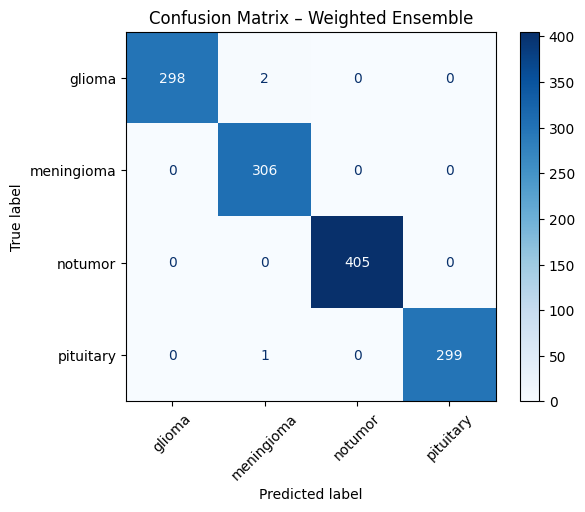

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def ensemble_predictions(models, loader, weights):
    y_true, y_pred = [], []

    for x, y in loader:
        x = x.to(device)
        probs = []

        for model in models.values():
            model.eval()
            with torch.no_grad():
                probs.append(torch.softmax(model(x), dim=1))

        probs = torch.stack(probs)
        weighted_prob = (weights[:, None, None] * probs).sum(dim=0)

        preds = weighted_prob.argmax(1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)


# ---- Run ----
y_true, y_pred = ensemble_predictions(models, test_loader, weights)


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_ds.class_to_idx.keys())
)


disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix – Weighted Ensemble")
plt.show()

In [ ]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

target_layers = {
    "ResNet50": models["ResNet50"].layer4[-1],
    "DenseNet121": models["DenseNet121"].features[-1],
    "ConvNeXt-Tiny": models["ConvNeXt-Tiny"].stages[-1]
}

In [ ]:
def gradcam_single(model, target_layer, img_tensor):
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))[0]
    return grayscale_cam

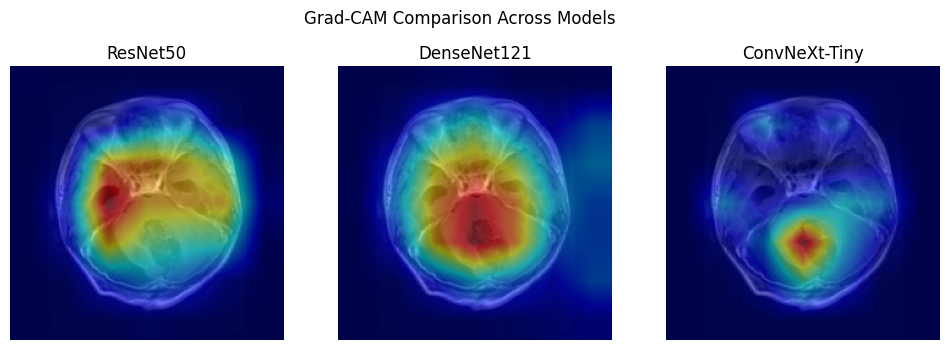

In [ ]:
x, y = next(iter(test_loader))
x = x.to(device)

img = x[0].cpu().permute(1,2,0).numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.figure(figsize=(12,4))

for i, (name, model) in enumerate(models.items()):
    cam = gradcam_single(model, target_layers[name], x[0])
    cam_img = show_cam_on_image(img, cam, use_rgb=True)

    plt.subplot(1,3,i+1)
    plt.imshow(cam_img)
    plt.title(name)
    plt.axis("off")

plt.suptitle("Grad-CAM Comparison Across Models")
plt.show()

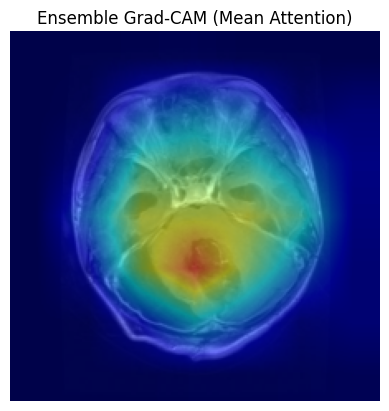

In [ ]:
cams = []
for name, model in models.items():
    cams.append(gradcam_single(model, target_layers[name], x[0]))

ensemble_cam = np.mean(np.stack(cams), axis=0)
ensemble_img = show_cam_on_image(img, ensemble_cam, use_rgb=True)

plt.imshow(ensemble_img)
plt.title("Ensemble Grad-CAM (Mean Attention)")
plt.axis("off")
plt.show()

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.77GB/s]


In [ ]:
import os

print(os.listdir("/content"))

['.config', 'Training', 'kaggle.json', 'Testing', 'sample_data']


In [ ]:
import os

print("Training folders:", os.listdir("/content/Training"))
print("Testing folders:", os.listdir("/content/Testing"))

Training folders: ['glioma_tumor', 'no_tumor', 'glioma', 'pituitary_tumor', 'meningioma_tumor', 'notumor', 'meningioma', 'pituitary']
Testing folders: ['glioma_tumor', 'no_tumor', 'glioma', 'pituitary_tumor', 'meningioma_tumor', 'notumor', 'meningioma', 'pituitary']


In [ ]:
import os

BASE_DIR = "/content"
CLEAN_TRAIN = "/content/CLEAN_Training"
CLEAN_TEST  = "/content/CLEAN_Testing"

classes = ["glioma", "meningioma", "pituitary", "no_tumor"]

for cls in classes:
    os.makedirs(os.path.join(CLEAN_TRAIN, cls), exist_ok=True)
    os.makedirs(os.path.join(CLEAN_TEST, cls), exist_ok=True)

In [ ]:
import shutil

mapping = {
    "glioma": ["glioma", "glioma_tumor"],
    "meningioma": ["meningioma", "meningioma_tumor"],
    "pituitary": ["pituitary", "pituitary_tumor"],
    "no_tumor": ["no_tumor", "notumor"]
}

def merge_folders(src_base, dst_base):
    for target_class, src_folders in mapping.items():
        for folder in src_folders:
            src_path = os.path.join(src_base, folder)
            if not os.path.exists(src_path):
                continue
            for img in os.listdir(src_path):
                shutil.copy(
                    os.path.join(src_path, img),
                    os.path.join(dst_base, target_class, img)
                )

merge_folders("/content/Training", CLEAN_TRAIN)
merge_folders("/content/Testing", CLEAN_TEST)

In [ ]:
print("Clean Training:", os.listdir(CLEAN_TRAIN))
print("Clean Testing:", os.listdir(CLEAN_TEST))

for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(CLEAN_TRAIN, cls)))} train images")

Clean Training: ['no_tumor', 'glioma', 'meningioma', 'pituitary']
Clean Testing: ['no_tumor', 'glioma', 'meningioma', 'pituitary']
glioma: 2147 train images
meningioma: 2161 train images
pituitary: 2284 train images
no_tumor: 1990 train images


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


test_tfms = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std =[0.229, 0.224, 0.225]
)
])


test_ds = datasets.ImageFolder(CLEAN_TEST, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


class_names = test_ds.classes
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [ ]:
import torch
for m in models.values():
    m.eval()
    m.to(device)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, loader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(1).cpu().numpy()

            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1, y_true, y_pred

In [ ]:
results = {}

for name, model in models.items():
    acc, f1, _, _ = evaluate_model(model, test_loader)
    results[name] = (acc, f1)
    print(f"{name} → Accuracy: {acc:.4f}, Macro-F1: {f1:.4f}")

ResNet50 → Accuracy: 0.9196, Macro-F1: 0.9171
DenseNet121 → Accuracy: 0.9425, Macro-F1: 0.9404
ConvNeXt-Tiny → Accuracy: 0.8809, Macro-F1: 0.8856


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.tensor([0.2, 0.5, 0.3], device=device)

from sklearn.metrics import accuracy_score, f1_score

def weighted_ensemble(models, loader, weights):
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)

            probs = []
            for model in models.values():
                probs.append(torch.softmax(model(x), dim=1))

            probs = torch.stack(probs)        # [3, B, C]
            weighted_prob = (weights[:,None,None] * probs).sum(0)

            preds = weighted_prob.argmax(1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return acc, f1, y_true, y_pred

In [ ]:
ens_acc, ens_f1, y_true, y_pred = weighted_ensemble(models, test_loader, weights)

print(f"Weighted Ensemble → Accuracy: {ens_acc:.4f}")
print(f"Weighted Ensemble → Macro-F1: {ens_f1:.4f}")

Weighted Ensemble → Accuracy: 0.9449
Weighted Ensemble → Macro-F1: 0.9432


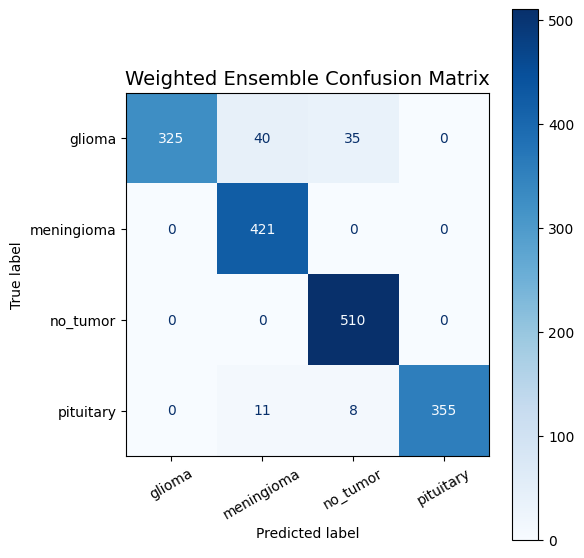

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(
    cmap="Blues",
    values_format="d",
    ax=plt.gca()
)

plt.title("Weighted Ensemble Confusion Matrix", fontsize=14)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

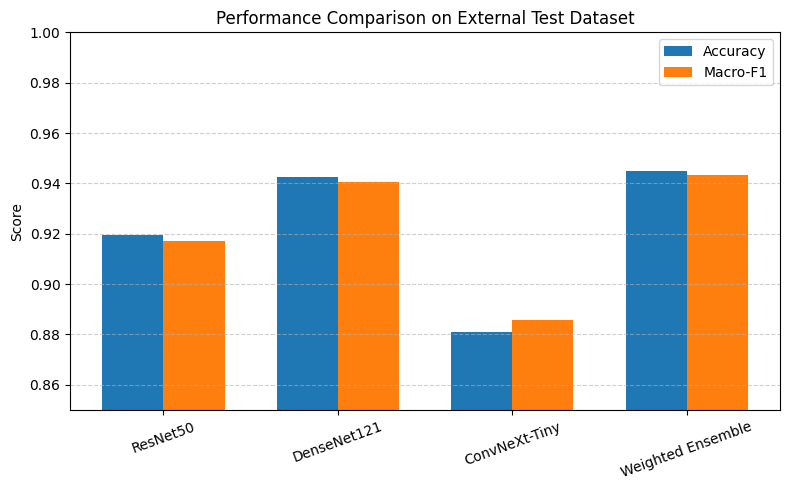

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models_names = [
    "ResNet50",
    "DenseNet121",
    "ConvNeXt-Tiny",
    "Weighted Ensemble"
]

accuracies = [
    0.9196,
    0.9425,
    0.8809,
    0.9449
]

macro_f1s = [
    0.9171,
    0.9404,
    0.8856,
    0.9432
]

x = np.arange(len(models_names))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, accuracies, width, label="Accuracy")
plt.bar(x + width/2, macro_f1s, width, label="Macro-F1")

plt.ylabel("Score")
plt.ylim(0.85, 1.0)
plt.xticks(x, models_names, rotation=20)
plt.title("Performance Comparison on External Test Dataset")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

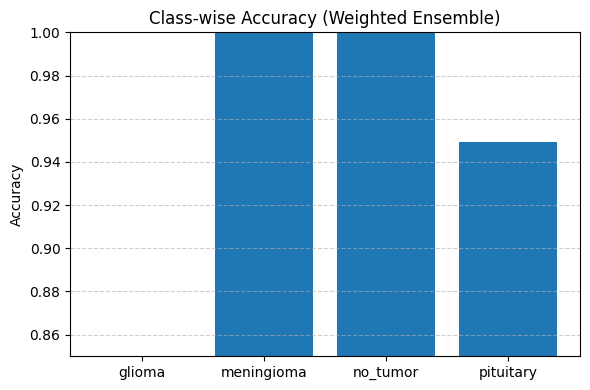

In [ ]:
import numpy as np

class_correct = np.zeros(len(class_names))
class_total   = np.zeros(len(class_names))

for t, p in zip(y_true, y_pred):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

class_acc = class_correct / class_total

plt.figure(figsize=(6,4))
plt.bar(class_names, class_acc)
plt.ylim(0.85, 1.0)
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy (Weighted Ensemble)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = {
    "ResNet50":     models["ResNet50"].layer4[-1],
    "DenseNet121":  models["DenseNet121"].features[-1],
    "ConvNeXt-Tiny":     models["ConvNeXt-Tiny"].stages[-1]
}

In [ ]:

indices = [5, 25, 50]

test_imgs = []
test_labels = []

for idx in indices:
    img, label = test_ds[idx]
    test_imgs.append(img)
    test_labels.append(label)

In [ ]:
def gradcam_single(model, target_layer, img_tensor):
    cam = GradCAM(
        model=model,
        target_layers=[target_layer]
    )

    input_tensor = img_tensor.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    img_np = img_tensor.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    cam_img = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    return cam_img

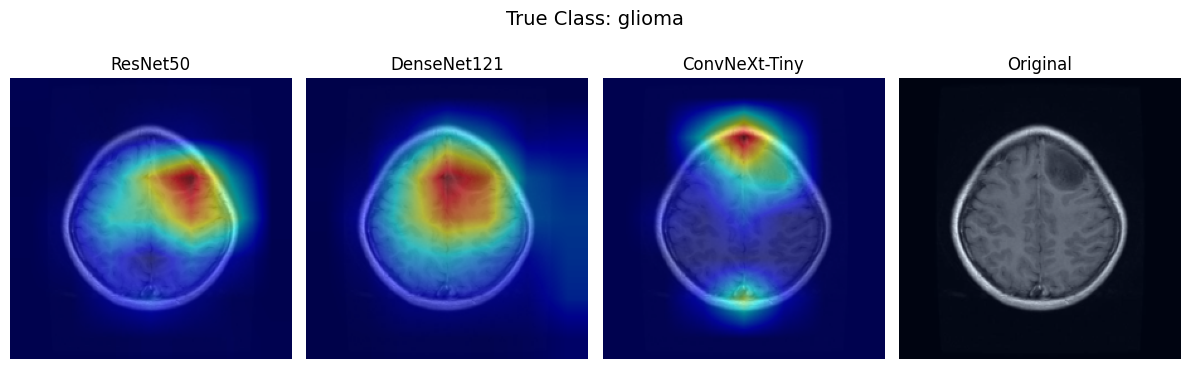

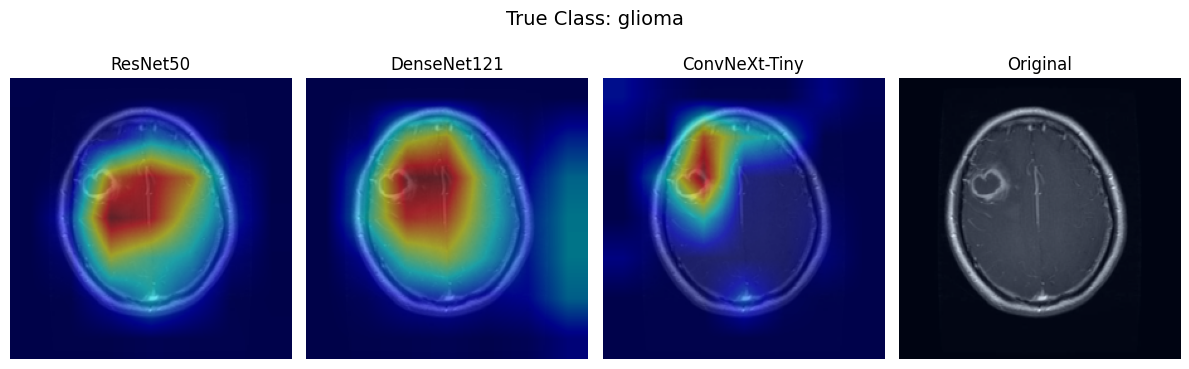

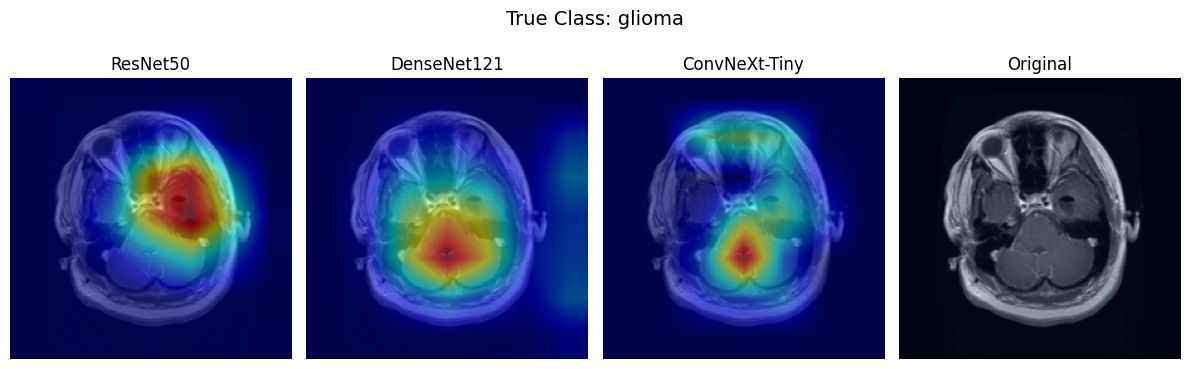

In [ ]:
for i, img in enumerate(test_imgs):
    plt.figure(figsize=(12,4))

    for j, (name, model) in enumerate(models.items()):
        cam_img = gradcam_single(
            model,
            target_layers[name],
            img
        )

        plt.subplot(1,4,j+1)
        plt.imshow(cam_img)
        plt.title(name)
        plt.axis("off")

    # original image
    plt.subplot(1,4,4)
    orig = img.permute(1,2,0).cpu().numpy()
    orig = (orig - orig.min()) / (orig.max() - orig.min())
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")

    plt.suptitle(f"True Class: {class_names[test_labels[i]]}", fontsize=14)
    plt.tight_layout()
    plt.show()

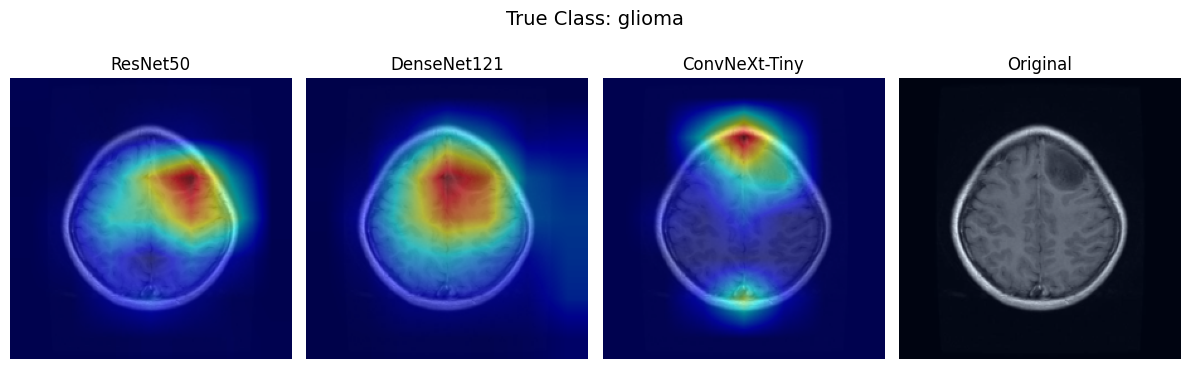

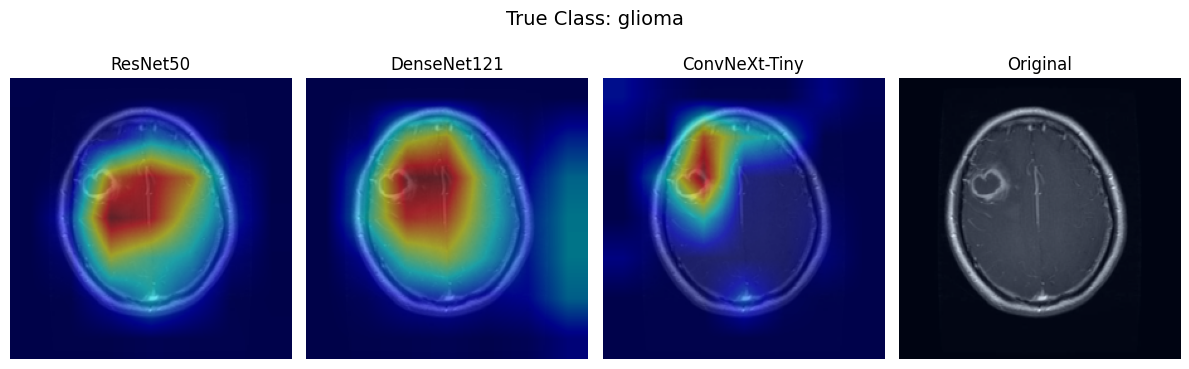

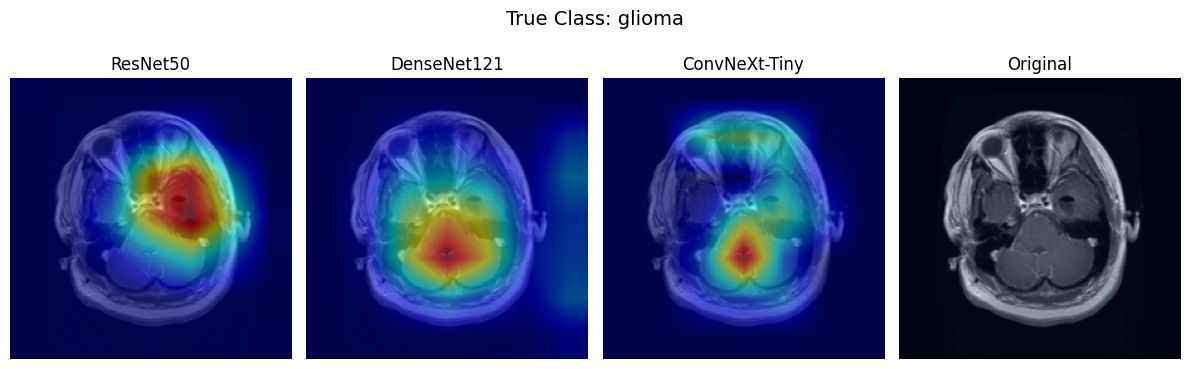

In [ ]:
for i, img in enumerate(test_imgs):
    plt.figure(figsize=(12,4))

    for j, (name, model) in enumerate(models.items()):
        cam_img = gradcam_single(
            model,
            target_layers[name],
            img
        )

        plt.subplot(1,4,j+1)
        plt.imshow(cam_img)
        plt.title(name)
        plt.axis("off")

    # original image
    plt.subplot(1,4,4)
    orig = img.permute(1,2,0).cpu().numpy()
    orig = (orig - orig.min()) / (orig.max() - orig.min())
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")

    plt.suptitle(f"True Class: {class_names[test_labels[i]]}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def ensemble_gradcam(models, target_layers, img_tensor):
    cams = []

    for name, model in models.items():
        cam = GradCAM(
            model=model,
            target_layers=[target_layers[name]]
        )

        grayscale = cam(
            input_tensor=img_tensor.unsqueeze(0).to(device)
        )[0]
        cams.append(grayscale)

    avg_cam = np.mean(cams, axis=0)

    img_np = img_tensor.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    cam_img = show_cam_on_image(img_np, avg_cam, use_rgb=True)
    return cam_img

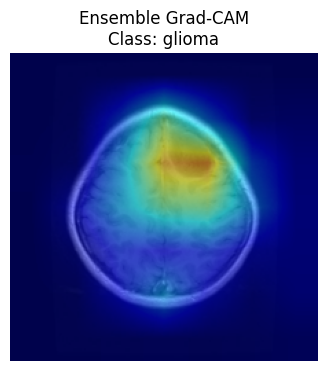

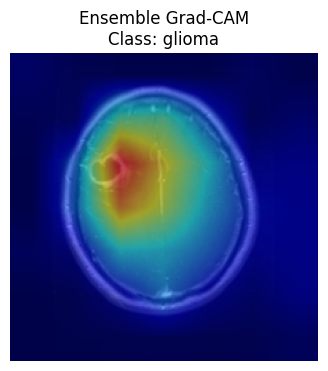

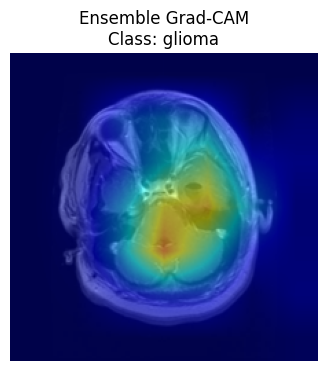

In [ ]:
for i, img in enumerate(test_imgs):
    cam_img = ensemble_gradcam(models, target_layers, img)

    plt.figure(figsize=(4,4))
    plt.imshow(cam_img)
    plt.title(f"Ensemble Grad-CAM\nClass: {class_names[test_labels[i]]}")
    plt.axis("off")
    plt.show()

In [ ]:
for i in indices:
    _, label = test_ds[i]
    print(i, class_names[label])

5 glioma
25 glioma
50 glioma


In [ ]:
selected = {}

for idx in range(len(test_ds)):
    _, label = test_ds[idx]
    cls = class_names[label]
    if cls not in selected:
        selected[cls] = idx
    if len(selected) == len(class_names):
        break

print(selected)

{'glioma': 0, 'meningioma': 400, 'no_tumor': 821, 'pituitary': 1331}


In [ ]:
indices = list(selected.values())

In [ ]:
def ensemble_predict(models, img):
    with torch.no_grad():
        probs = []
        for m in models.values():
            probs.append(torch.softmax(m(img.unsqueeze(0).to(device)), dim=1))
        avg_prob = torch.mean(torch.stack(probs), dim=0)
        return avg_prob.argmax(1).item()

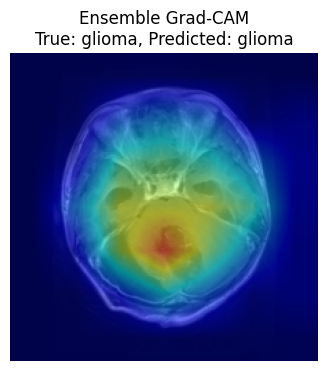

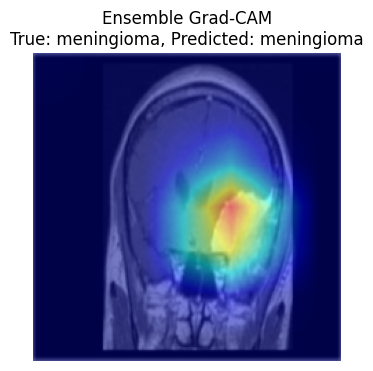

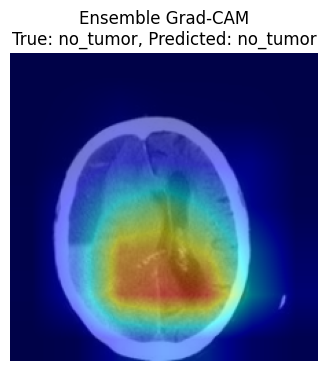

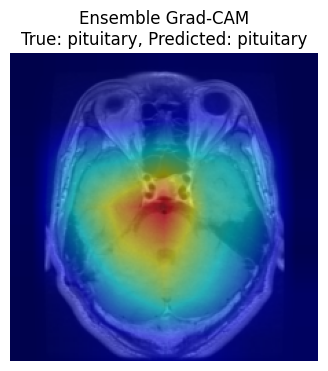

In [ ]:
for i in indices:
    img, true_label = test_ds[i]

    #  ensemble Grad-CAM
    cam_img = ensemble_gradcam(models, target_layers, img)

    #  ensemble prediction
    predicted_label = ensemble_predict(models, img)

    plt.figure(figsize=(4,4))
    plt.imshow(cam_img)
    plt.title(f"Ensemble Grad-CAM\nTrue: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
    plt.axis("off")
    plt.show()

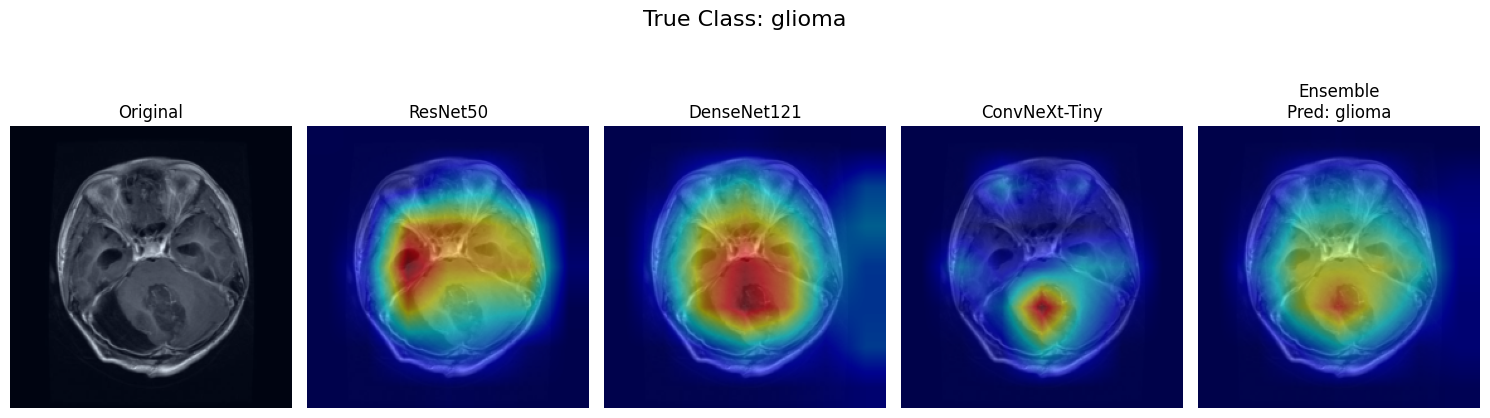

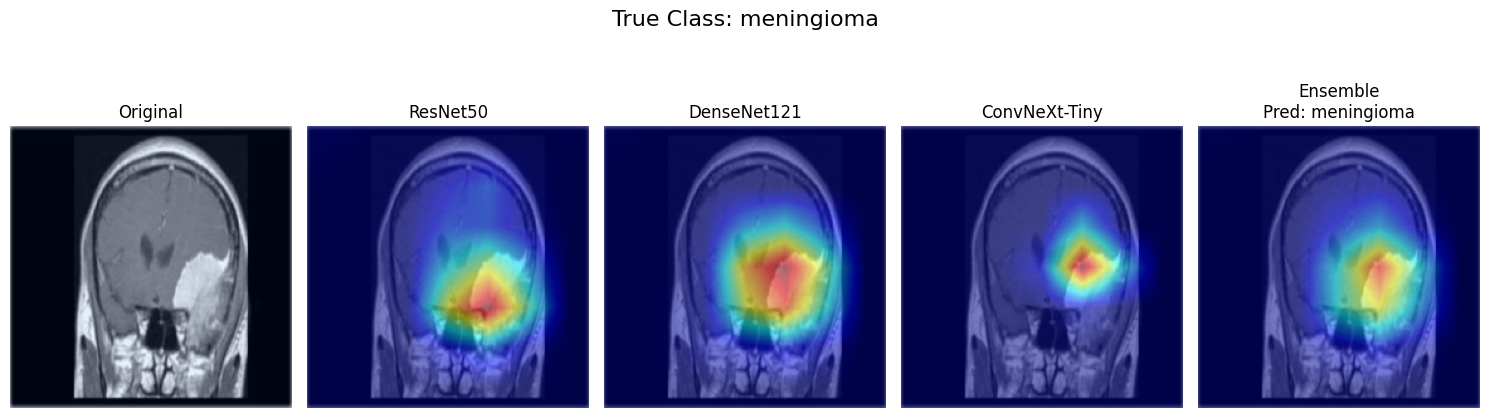

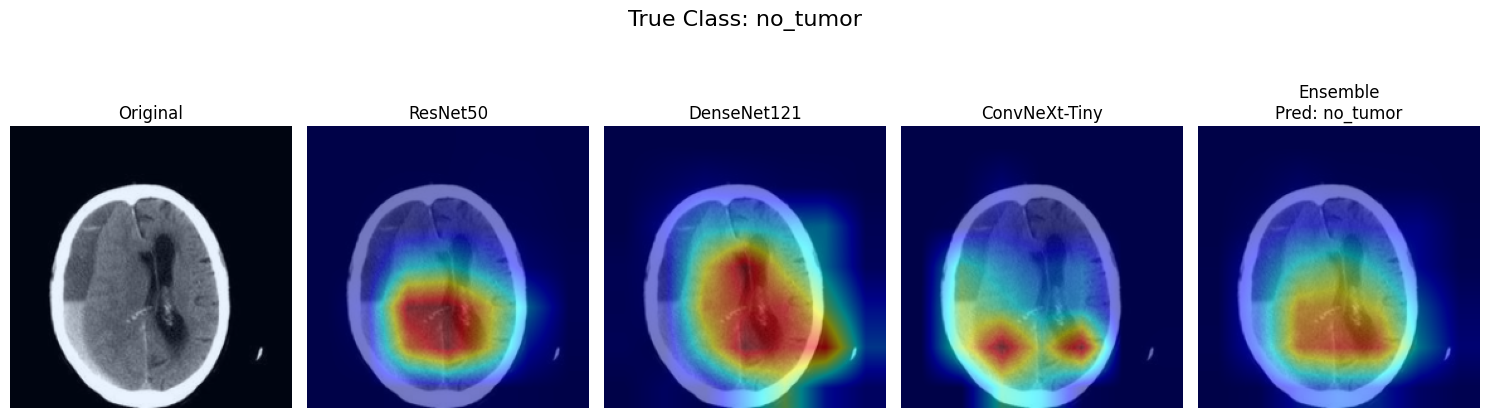

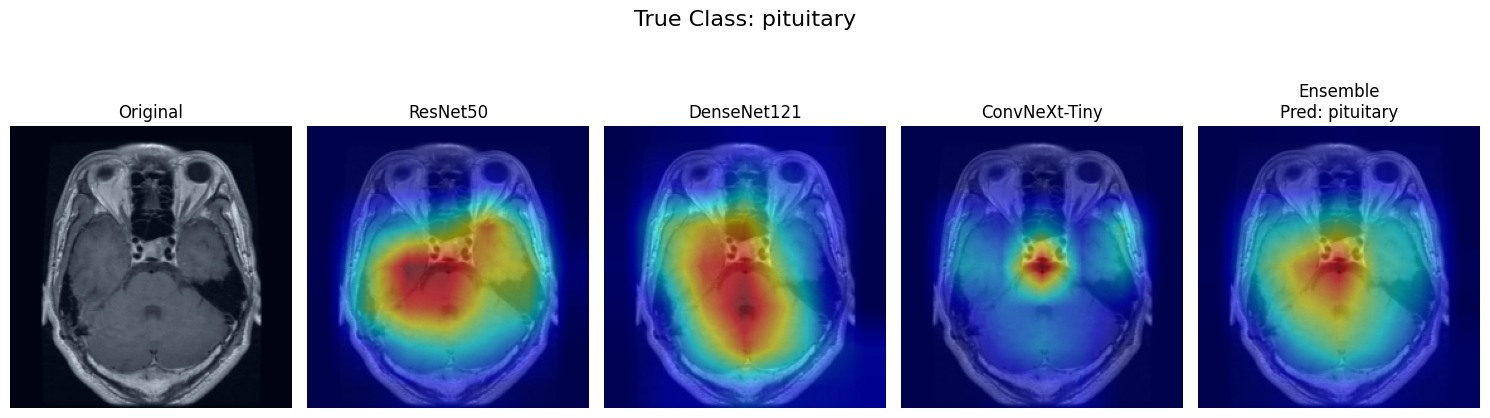

In [ ]:
for idx in indices:
    img, true_label = test_ds[idx]

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"True Class: {class_names[true_label]}", fontsize=16)

    plt.subplot(1, len(models) + 2, 1)
    orig = img.permute(1,2,0).cpu().numpy()
    orig = (orig - orig.min()) / (orig.max() - orig.min())
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")


    for i, (name, model) in enumerate(models.items()):
        cam_img = gradcam_single(
            model,
            target_layers[name],
            img
        )
        plt.subplot(1, len(models) + 2, i + 2)
        plt.imshow(cam_img)
        plt.title(name)
        plt.axis("off")

    ensemble_cam_img = ensemble_gradcam(models, target_layers, img)
    predicted_label = ensemble_predict(models, img)
    plt.subplot(1, len(models) + 2, len(models) + 2)
    plt.imshow(ensemble_cam_img)
    plt.title(f"Ensemble\nPred: {class_names[predicted_label]}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


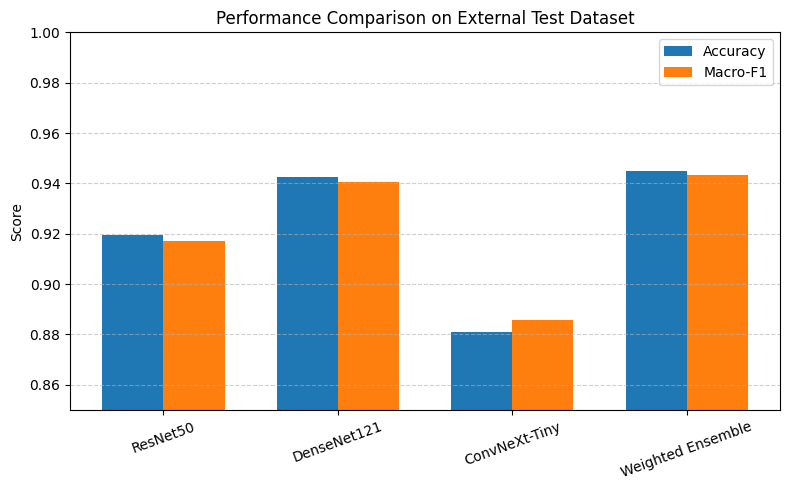

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models_names = [
    "ResNet50",
    "DenseNet121",
    "ConvNeXt-Tiny",
    "Weighted Ensemble"
]

accuracies = [
    0.9196,
    0.9425,
    0.8809,
    0.9449
]

macro_f1s = [
    0.9171,
    0.9404,
    0.8856,
    0.9432
]

x = np.arange(len(models_names))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, accuracies, width, label="Accuracy")
plt.bar(x + width/2, macro_f1s, width, label="Macro-F1")

plt.ylabel("Score")
plt.ylim(0.85, 1.0)
plt.xticks(x, models_names, rotation=20)
plt.title("Performance Comparison on External Test Dataset")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

### Upload a new MRI image for prediction and Grad-CAM visualization

In [ ]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()


filename = next(iter(uploaded))
img_path = io.BytesIO(uploaded[filename])
image = Image.open(img_path).convert('RGB')
input_image = test_tfms(image)

print(f"Uploaded image '{filename}' preprocessed successfully.")

Saving OIP (6).jpg to OIP (6).jpg
Uploaded image 'OIP (6).jpg' preprocessed successfully.


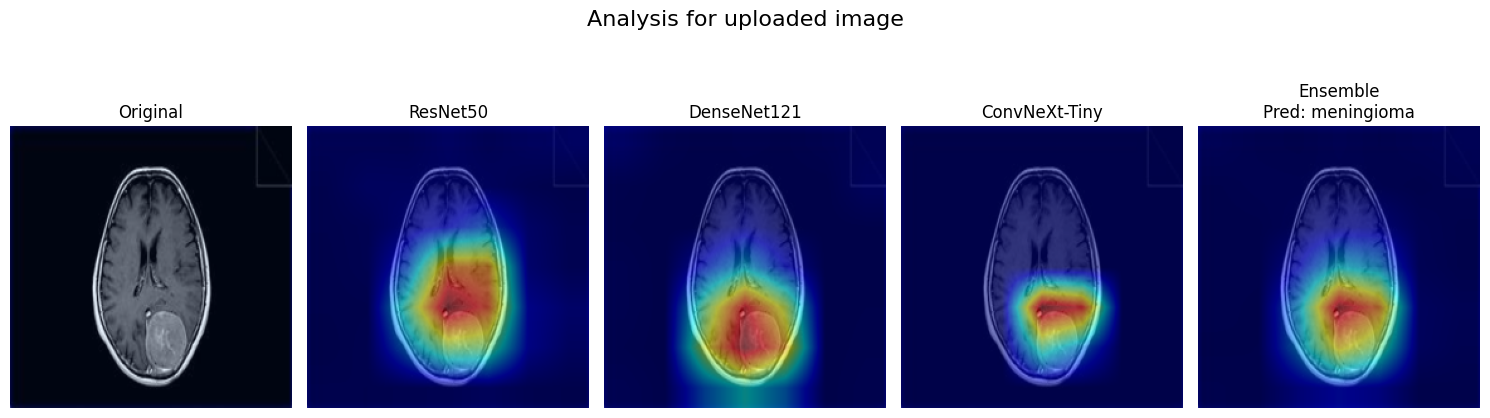

The ensemble model predicts the tumor type as: meningioma


In [ ]:
plt.figure(figsize=(15, 5))
plt.suptitle(f"Analysis for uploaded image", fontsize=16)
plt.subplot(1, len(models) + 2, 1)
orig_display = input_image.permute(1,2,0).cpu().numpy()
orig_display = (orig_display - orig_display.min()) / (orig_display.max() - orig_display.min())
plt.imshow(orig_display)
plt.title("Original")
plt.axis("off")

for i, (name, model) in enumerate(models.items()):
    cam_img = gradcam_single(
        model,
        target_layers[name],
        input_image
    )
    plt.subplot(1, len(models) + 2, i + 2)
    plt.imshow(cam_img)
    plt.title(name)
    plt.axis("off")


ensemble_cam_img = ensemble_gradcam(models, target_layers, input_image)
predicted_label_idx = ensemble_predict(models, input_image)
predicted_label_name = class_names[predicted_label_idx]

plt.subplot(1, len(models) + 2, len(models) + 2)
plt.imshow(ensemble_cam_img)
plt.title(f"Ensemble\nPred: {predicted_label_name}")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"The ensemble model predicts the tumor type as: {predicted_label_name}")

In [ ]:
from google.colab import files
from PIL import Image
import io
uploaded = files.upload()
filename = next(iter(uploaded))
img_path = io.BytesIO(uploaded[filename])
image = Image.open(img_path).convert('RGB')
input_image = test_tfms(image)

print(f"Uploaded image '{filename}' preprocessed successfully.")

Saving 1_BGxLxoHd8MG9m8gesYIprw.jpg to 1_BGxLxoHd8MG9m8gesYIprw.jpg
Uploaded image '1_BGxLxoHd8MG9m8gesYIprw.jpg' preprocessed successfully.


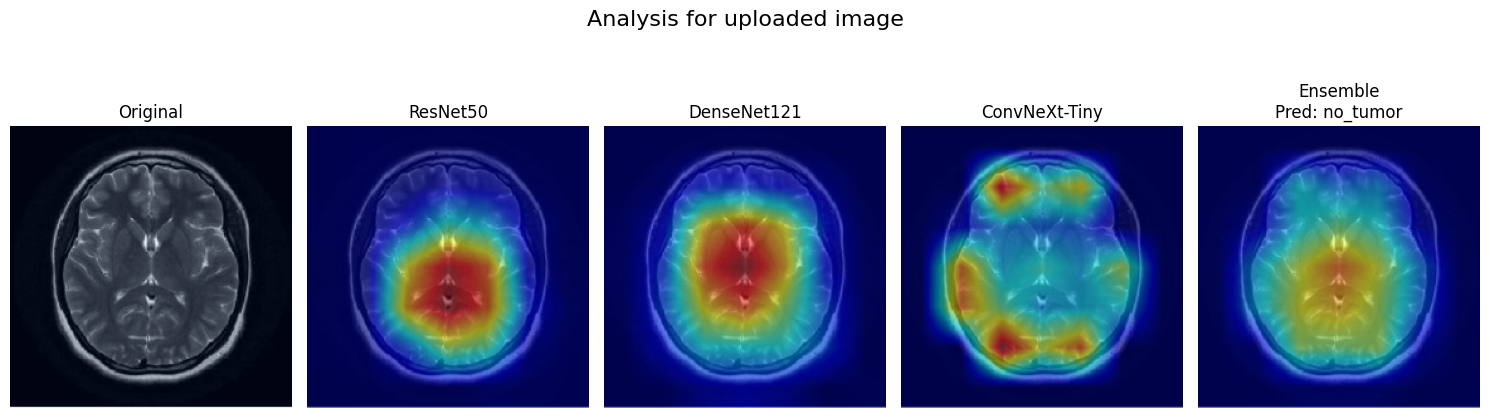

The ensemble model predicts the tumor type as: no_tumor


In [ ]:
plt.figure(figsize=(15, 5))
plt.suptitle(f"Analysis for uploaded image", fontsize=16)


plt.subplot(1, len(models) + 2, 1)
orig_display = input_image.permute(1,2,0).cpu().numpy()
orig_display = (orig_display - orig_display.min()) / (orig_display.max() - orig_display.min())
plt.imshow(orig_display)
plt.title("Original")
plt.axis("off")


for i, (name, model) in enumerate(models.items()):
    cam_img = gradcam_single(
        model,
        target_layers[name],
        input_image
    )
    plt.subplot(1, len(models) + 2, i + 2)
    plt.imshow(cam_img)
    plt.title(name)
    plt.axis("off")


ensemble_cam_img = ensemble_gradcam(models, target_layers, input_image)
predicted_label_idx = ensemble_predict(models, input_image)
predicted_label_name = class_names[predicted_label_idx]

plt.subplot(1, len(models) + 2, len(models) + 2)
plt.imshow(ensemble_cam_img)
plt.title(f"Ensemble\nPred: {predicted_label_name}")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"The ensemble model predicts the tumor type as: {predicted_label_name}")